## 1. Import relevant packages

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
!pip install torch-summary==1.4.4 
from torchsummary import summary

import utilities
import read_data
import prototypical_network
import train_and_evaluation


## 2. Device

In [2]:
# get the computational device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 3. Get data

We are going to use data in the test set.

In [3]:
%%time
# we want to resize all our images to 224x224
img_height, img_width = 224, 224
data_dir = utilities.test_data_dir
x_test, y_test = read_data.read_eye_images(data_dir, img_height, img_width, augmentation=False)

CPU times: total: 1.09 s
Wall time: 3.35 s


In [4]:
# check the shape of our data
x_test.shape, y_test.shape

((180, 224, 224, 3), (180,))

## 4. Display example images

Before running a model with any data, you should have a visual inspection of the data first.

Class labels sampled: ['keratoconus' 'pterygium' 'glaucoma']


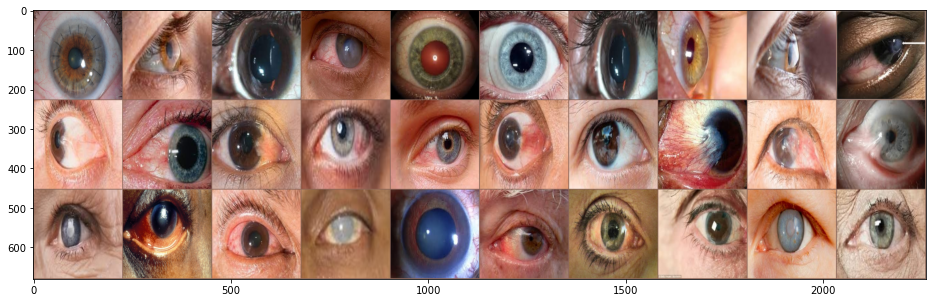

In [5]:
# As an example, lets pick a sample with the following
n_way = 3     # no. of classes --> Remember due to augmentation we now have 28 classes to sample from
n_support = 5 # no. of support images per class
n_query = 5   # no. of qiery images per class
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test) #  returns a dictionary
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

## 5. Download pretrained model

In [6]:
densenet121_model = models.densenet121(pretrained=True)

**5a. Model architecture**

In [7]:

densenet121_model = densenet121_model.to(device)
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**5b. Summarize model**

Here you get to understand input and output image sizes as the model extracts features from each image. You also find out the number of parameters in your model

In [8]:
summary(densenet121_model, (3, 224, 244), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

**5c. Freeze the model**

This stops any parameter updates during backpropagation

In [9]:
for param in densenet121_model.parameters():
  param.requires_grad = False

**5d. Flatten outputs from the Convolutional base networks and remove the Linear layers**

In [10]:
densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

## 6. Test the accuracy of your model

In [ ]:
# Lets test our Prototypical Network Model 

prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

## 7. Make predictions

In [ ]:
# Lets ask our model to predict on (n_query) tasks

prototypical_model.to(device)
n_way = 3
n_support = 5
n_query = 10 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

# display the sample images used
train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")


# display the test results
print(results)
 